# Week 1 - Tasks

- **Data Source:** `yfinance`
- **Assets:** `AAPL`, `MSFT`, `GOOG`, `AMZN`, `TSLA` (and `NVDA` for Task 5)
- **Timeframes:**
  * **Long Term:** `start="2015-01-01", end="2024-01-01"`
  * **Medium Term:** `start="2020-01-01", end="2024-01-01"` (Includes COVID crash)

The goal for this week is to gain familiarity with financial data, analyze common trends, learn standard library functions, and touch upon the underlying theory.

## Task 1 - Setup
* Fetch **Long Term** historical data for the 5 assets.
* Extract the `Adjusted Close` values.
    * *Note: Check for missing values or empty rows and handle them (drop or fill).*
* Use `df.describe()` to extract key summary statistics.
* Extract the **Medium Term** data as well for later tasks.

In [1]:
#Task 1
# 0. Imports and settings
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# nicer plots in notebooks
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)
sns.set(style="whitegrid")

# 1. Parameters
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA","NVDA"]

long_start  = "2015-01-01"
long_end    = "2024-01-01"

med_start   = "2021-01-01"
med_end     = "2024-01-01"

In [3]:
# 2. Fetch long-term and medium-term data
print("Downloading long-term data...")
long_data = yf.download(tickers, start=long_start, end=long_end, progress=False, group_by='ticker')

print("Downloading medium-term data...")
med_data  = yf.download(tickers, start=med_start, end=med_end, progress=False, group_by='ticker')

/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/3795499085.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  long_data = yf.download(tickers, start=long_start, end=long_end, progress=False, group_by='ticker')


/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/3795499085.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  med_data  = yf.download(tickers, start=med_start, end=med_end, progress=False, group_by='ticker')


In [4]:
def extract_adj_close_and_volume(yf_df, tickers):
    """
    Extract Adjusted Close and Volume into clean DataFrames for multiple tickers.
    Handles both auto_adjust=True and False versions of yfinance.
    """
    adj_dict = {}
    vol_dict = {}

    for t in tickers:
        df = yf_df[t]
        # Adjusted Close may not exist if auto_adjust=True
        if 'Adj Close' in df.columns:
            adj_dict[t] = df['Adj Close']
        elif 'Close' in df.columns:
            adj_dict[t] = df['Close']  # fallback
        else:
            raise KeyError(f"No Adjusted Close or Close found for {t}")

        if 'Volume' in df.columns:
            vol_dict[t] = df['Volume']
        else:
            raise KeyError(f"No Volume column found for {t}")

    adj = pd.DataFrame(adj_dict)
    vol = pd.DataFrame(vol_dict)
    return adj, vol
# Call the helper function on your downloaded data
long_adj, long_vol = extract_adj_close_and_volume(long_data, tickers)
med_adj,  med_vol  = extract_adj_close_and_volume(med_data, tickers)

# Quick check: display first few rows
print("Long-term Adjusted Close:")
display(long_adj.head())

print("\nMedium-term Adjusted Close:")
display(med_adj.head())

Long-term Adjusted Close:


,AAPL,MSFT,GOOG,AMZN,TSLA,NVDA
Date,,,,,,
2015-01-02,24.237551,39.858459,25.973846,15.4260,14.620667,0.483011
2015-01-05,23.554739,39.491920,25.432405,15.1095,14.006000,0.474853
2015-01-06,23.556959,38.912292,24.842955,14.7645,14.085333,0.460457
2015-01-07,23.887281,39.406693,24.800394,14.9210,14.063333,0.459257
2015-01-08,24.805080,40.565952,24.878588,15.0230,14.041333,0.476533



Medium-term Adjusted Close:


,AAPL,MSFT,GOOG,AMZN,TSLA,NVDA
Date,,,,,,
2021-01-04,125.974472,208.882202,85.768730,159.331497,243.256668,13.076725
2021-01-05,127.531967,209.083694,86.398018,160.925507,245.036667,13.367163
2021-01-06,123.239052,203.662323,86.118584,156.919006,251.993332,12.579125
2021-01-07,127.444374,209.457947,88.697258,158.108002,272.013336,13.306579
2021-01-08,128.544418,210.734131,89.687820,159.134995,293.339996,13.239518


In [5]:
# 4. Deal with missing values / rows
# Strategy:
#  - drop rows where all assets are NaN (market holiday outside tickers scope)
#  - forward-fill then backward-fill for short gaps
long_adj = long_adj.dropna(how='all')
long_vol = long_vol.loc[long_adj.index]  # keep same index (in case)
long_adj = long_adj.fillna(method='ffill').fillna(method='bfill')

med_adj = med_adj.dropna(how='all')
med_vol  = med_vol.loc[med_adj.index]
med_adj = med_adj.fillna(method='ffill').fillna(method='bfill')

/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/1485686537.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  long_adj = long_adj.fillna(method='ffill').fillna(method='bfill')
/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/1485686537.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  med_adj = med_adj.fillna(method='ffill').fillna(method='bfill')


In [6]:
# 5. Quick stats: pandas describe
print("\nLong-term Adjusted Close stats (describe):")
display(long_adj.describe().T)   # display works nicely in notebooks

print("\nMedium-term Adjusted Close stats (describe):")
display(med_adj.describe().T)


Long-term Adjusted Close stats (describe):


,count,mean,std,min,25%,50%,75%,max
AAPL,2264.0,81.394710,55.990879,20.604074,32.814692,51.220844,139.017620,196.256561
MSFT,2264.0,154.516907,99.658478,34.437164,59.182488,127.528809,244.037373,377.077850
GOOG,2264.0,73.063479,36.298158,24.377235,41.515254,59.376667,104.133984,149.587082
AMZN,2264.0,91.950540,48.654536,14.347500,44.303625,90.691998,133.230000,186.570496
TSLA,2264.0,102.886245,110.936400,9.578000,16.670500,23.160666,214.290005,409.970001
NVDA,2264.0,11.101311,11.961935,0.459257,2.668013,5.962060,15.909116,50.376503



Medium-term Adjusted Close stats (describe):


,count,mean,std,min,25%,50%,75%,max
AAPL,753.0,153.396934,20.089676,113.440193,139.071899,150.273697,170.006332,196.256561
MSFT,753.0,278.432958,40.420555,203.662323,244.206009,274.943756,312.543274,377.077820
GOOG,753.0,119.225736,17.323682,82.868469,104.168716,120.162766,135.170197,149.587051
AMZN,753.0,138.282507,27.465044,81.820000,115.010002,140.389999,163.408005,186.570496
TSLA,753.0,246.911965,55.585519,108.099998,211.250000,242.399994,279.820007,409.970001
NVDA,753.0,24.830579,11.193206,11.212906,15.971013,21.243732,29.398449,50.376499


## Task 2 - Basic Trends
* Select **one asset** and using the **Medium Term** data, compute:
    * **Returns:** 1-day, 5-day, and 20-day simple returns.
    * **Log Returns:** 1-day, 5-day, and 20-day log returns.
    * **Volatility:** 5-day, 20-day, and 60-day rolling standard deviation (volatility) of the log returns.
* **Plotting:**
    * Plot the price and the 20-day moving average on one chart.
    * Plot the 1-day log returns on a separate chart.
    * Plot the rolling volatilities on a third chart.
    * *Analysis:* What trends do you observe? Does high volatility correlate with price drops?

* **Bonus (Long Term Data):**
    * Create a scatter plot of `|Daily Return|` vs `Volume`. Is there a relationship?
    * Group returns and volatility by **Month** (e.g., all Januaries, all Februaries) and plot the averages. Is there a "seasonal" effect?

In [7]:
# 6. Task 2: Basic trends for one asset (choose one) - use medium-term data
asset = "AAPL"   # change this to any of tickers list
price = med_adj[asset].copy()

# Simple returns: pct_change for periods 1, 5, 20
med_adj[f"{asset}_ret_1d_simple"]  = price.pct_change(periods=1)
med_adj[f"{asset}_ret_5d_simple"]  = price.pct_change(periods=5)
med_adj[f"{asset}_ret_20d_simple"] = price.pct_change(periods=20)

# Log returns: np.log(Price_t / Price_{t-k})
med_adj[f"{asset}_ret_1d_log"]  = np.log(price / price.shift(1))
med_adj[f"{asset}_ret_5d_log"]  = np.log(price / price.shift(5))
med_adj[f"{asset}_ret_20d_log"] = np.log(price / price.shift(20))

# Volatility: rolling std of log returns
# We'll compute rolling std (daily) and also annualized (std * sqrt(252))
sqrt252 = np.sqrt(252)

med_adj[f"{asset}_logret_1d"] = med_adj[f"{asset}_ret_1d_log"]  # convenience

med_adj[f"{asset}_vol_5d_raw"]  = med_adj[f"{asset}_logret_1d"].rolling(window=5).std()
med_adj[f"{asset}_vol_20d_raw"] = med_adj[f"{asset}_logret_1d"].rolling(window=20).std()
med_adj[f"{asset}_vol_60d_raw"] = med_adj[f"{asset}_logret_1d"].rolling(window=60).std()

med_adj[f"{asset}_vol_5d_ann"]  = med_adj[f"{asset}_vol_5d_raw"]  * sqrt252
med_adj[f"{asset}_vol_20d_ann"] = med_adj[f"{asset}_vol_20d_raw"] * sqrt252
med_adj[f"{asset}_vol_60d_ann"] = med_adj[f"{asset}_vol_60d_raw"] * sqrt252

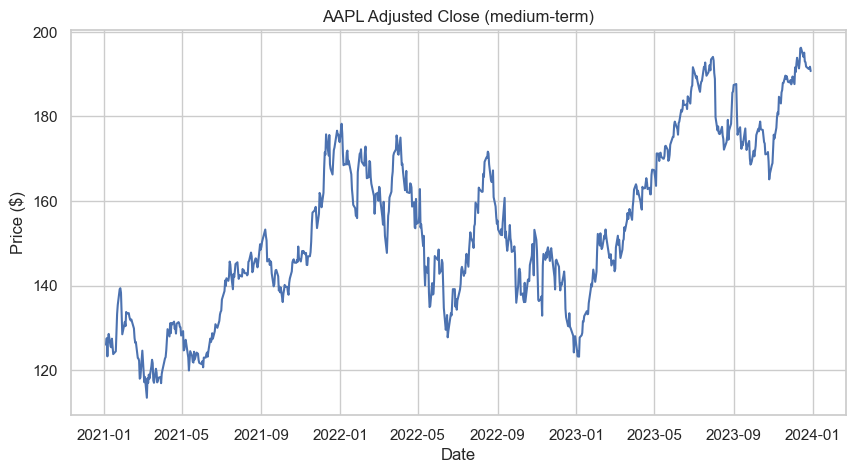

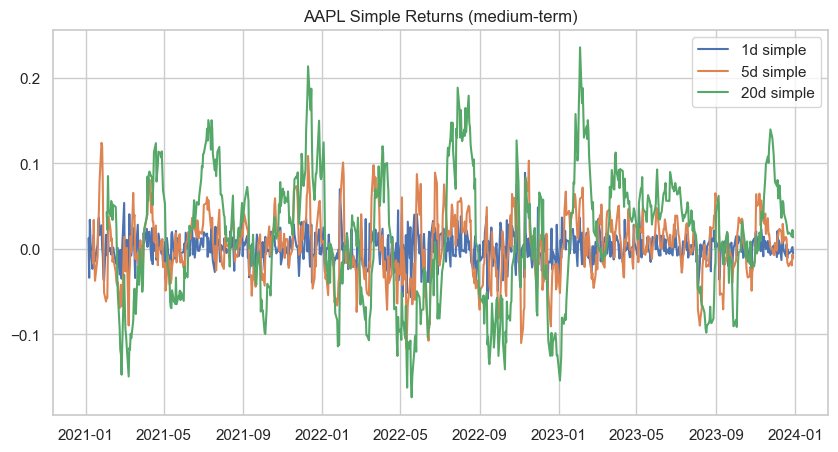

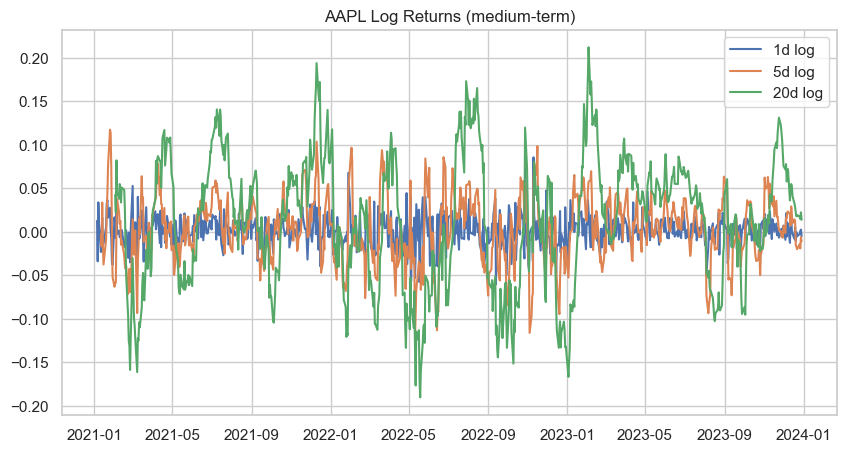

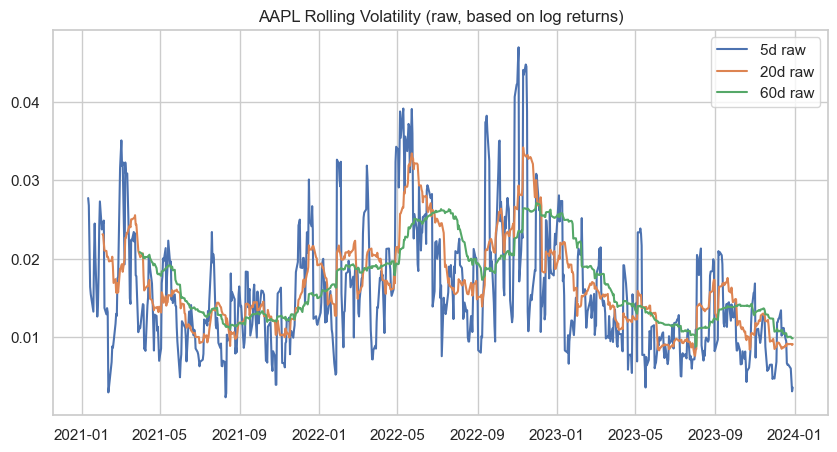

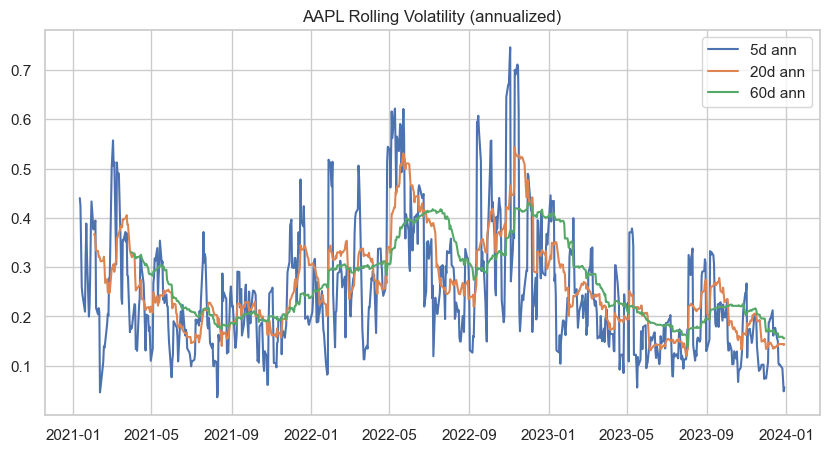

In [8]:
# 7. Plotting - each pointer on a separate graph (as requested)
# 7a. Price
fig, ax = plt.subplots()
ax.plot(price.index, price.values)
ax.set_title(f"{asset} Adjusted Close (medium-term)")
ax.set_ylabel("Price ($)")
ax.set_xlabel("Date")
plt.show()

# 7b. Simple returns (1d, 5d, 20d)
fig, ax = plt.subplots()
ax.plot(med_adj.index, med_adj[f"{asset}_ret_1d_simple"], label="1d simple")
ax.plot(med_adj.index, med_adj[f"{asset}_ret_5d_simple"], label="5d simple")
ax.plot(med_adj.index, med_adj[f"{asset}_ret_20d_simple"], label="20d simple")
ax.set_title(f"{asset} Simple Returns (medium-term)")
ax.legend()
plt.show()

# 7c. Log returns (1d, 5d, 20d)
fig, ax = plt.subplots()
ax.plot(med_adj.index, med_adj[f"{asset}_ret_1d_log"], label="1d log")
ax.plot(med_adj.index, med_adj[f"{asset}_ret_5d_log"], label="5d log")
ax.plot(med_adj.index, med_adj[f"{asset}_ret_20d_log"], label="20d log")
ax.set_title(f"{asset} Log Returns (medium-term)")
ax.legend()
plt.show()

# 7d. Volatility raw (5d, 20d, 60d) - daily std
fig, ax = plt.subplots()
ax.plot(med_adj.index, med_adj[f"{asset}_vol_5d_raw"], label="5d raw")
ax.plot(med_adj.index, med_adj[f"{asset}_vol_20d_raw"], label="20d raw")
ax.plot(med_adj.index, med_adj[f"{asset}_vol_60d_raw"], label="60d raw")
ax.set_title(f"{asset} Rolling Volatility (raw, based on log returns)")
ax.legend()
plt.show()

# 7e. Volatility annualized
fig, ax = plt.subplots()
ax.plot(med_adj.index, med_adj[f"{asset}_vol_5d_ann"], label="5d ann")
ax.plot(med_adj.index, med_adj[f"{asset}_vol_20d_ann"], label="20d ann")
ax.plot(med_adj.index, med_adj[f"{asset}_vol_60d_ann"], label="60d ann")
ax.set_title(f"{asset} Rolling Volatility (annualized)")
ax.legend()
plt.show()

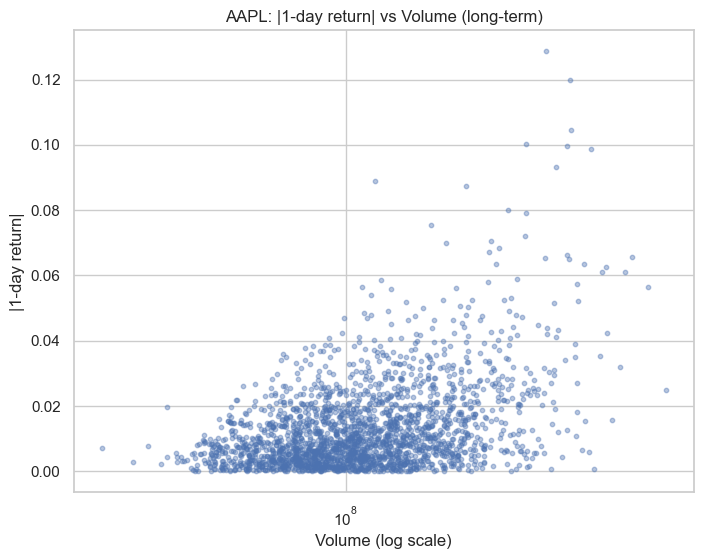

In [9]:
# 8. Bonus: scatter |return| vs Volume (long-term)
# Use 1-day simple returns for the chosen asset over the long term
long_returns_1d = long_adj[asset].pct_change()
long_volume = long_vol[asset].reindex(long_returns_1d.index)

# Drop NaNs for plotting
scatter_df = pd.DataFrame({
    "abs_return": long_returns_1d.abs(),
    "volume": long_volume
}).dropna()

plt.figure(figsize=(8,6))
plt.scatter(scatter_df["volume"], scatter_df["abs_return"], alpha=0.4, s=10)
plt.xscale('log')  # volumes can be skewed; log scale helps
plt.xlabel("Volume (log scale)")
plt.ylabel("|1-day return|")
plt.title(f"{asset}: |1-day return| vs Volume (long-term)")
plt.show()

/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/1530772921.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean_ret = long_log_returns.resample('M').mean()
/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/1530772921.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_vol = long_log_returns.resample('M').std() * np.sqrt(252)  # monthly windows annualized for comparability


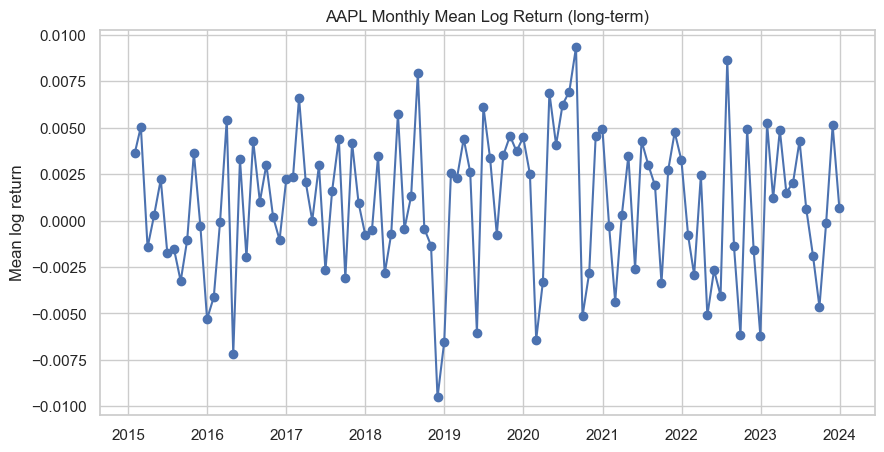

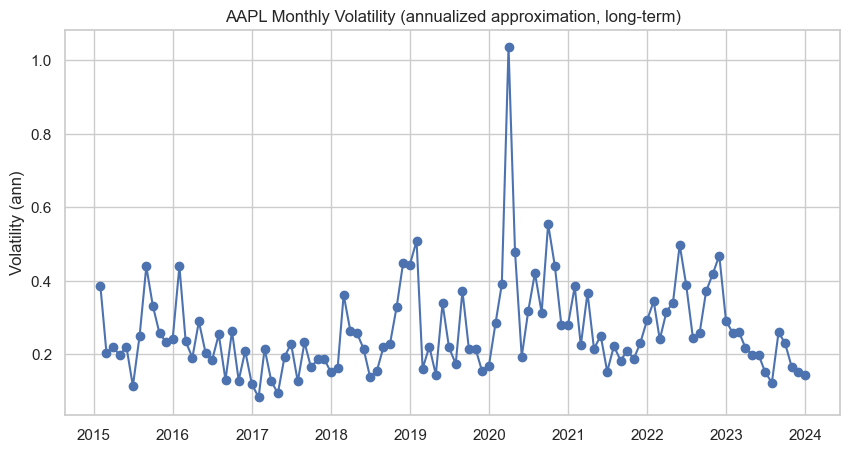


--- Quick analysis template ---
1) Look at price trend: rising/falling/sideways over medium-term?
2) Are 5d/20d returns smoothing the 1d returns as expected?
3) Do vol spikes correspond to known drawdowns or price jumps?
4) In the scatter plot: do larger volumes link to larger |returns|? (outliers matter)
5) Monthly group stats: any seasonal patterns? months with consistently higher volatility?

Fill these with your observations and link to events or earnings releases if you want deeper analysis.


In [10]:
# 9. Bonus: Returns & volatility grouped by month (long-term)
# We'll compute monthly mean returns and monthly volatility (std of daily log returns)
long_log_returns = np.log(long_adj / long_adj.shift(1))
monthly_mean_ret = long_log_returns.resample('M').mean()
monthly_vol = long_log_returns.resample('M').std() * np.sqrt(252)  # monthly windows annualized for comparability

# Plot monthly mean returns for the asset
fig, ax = plt.subplots()
ax.plot(monthly_mean_ret.index, monthly_mean_ret[asset], marker='o')
ax.set_title(f"{asset} Monthly Mean Log Return (long-term)")
ax.set_ylabel("Mean log return")
plt.show()

# Plot monthly volatility
fig, ax = plt.subplots()
ax.plot(monthly_vol.index, monthly_vol[asset], marker='o')
ax.set_title(f"{asset} Monthly Volatility (annualized approximation, long-term)")
ax.set_ylabel("Volatility (ann)")
plt.show()

# 10. Quick analysis notes (fill these in your notebook)
print("\n--- Quick analysis template ---")
print("1) Look at price trend: rising/falling/sideways over medium-term?")
print("2) Are 5d/20d returns smoothing the 1d returns as expected?")
print("3) Do vol spikes correspond to known drawdowns or price jumps?")
print("4) In the scatter plot: do larger volumes link to larger |returns|? (outliers matter)")
print("5) Monthly group stats: any seasonal patterns? months with consistently higher volatility?")
print("\nFill these with your observations and link to events or earnings releases if you want deeper analysis.")

## Task 3 - Stationarity
* Select **one asset** (Long Term).
* Compute the **Rolling Mean** and **Rolling Standard Deviation** of log returns with window sizes `20, 60, 120`.
* Plot them and visually inspect.
    * Does the mean stay constant? (Stationary mean)
    * Does the variance stay constant? (Stationary variance)
* Run an **Augmented Dickey-Fuller (ADF) Test** on the log return series.
    * Library: `from statsmodels.tsa.stattools import adfuller`
    * *Goal:* Interpret the p-value. The Null Hypothesis ($H_0$) is that the series is non-stationary (has a unit root). If p-value < 0.05, we reject $H_0$.
    * For learning about hypothesis testing and p-value you can refer to CS215 slides or other standard resources mentioned in READMEs.

In [11]:
#Task 3
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

asset = "AAPL"   # choose any one ticker

In [12]:
# Log returns
log_ret = np.log(long_adj[asset] / long_adj[asset].shift(1)).dropna()

log_ret.head()
roll_mean_20  = log_ret.rolling(window=20).mean()
roll_mean_60  = log_ret.rolling(window=60).mean()
roll_mean_120 = log_ret.rolling(window=120).mean()

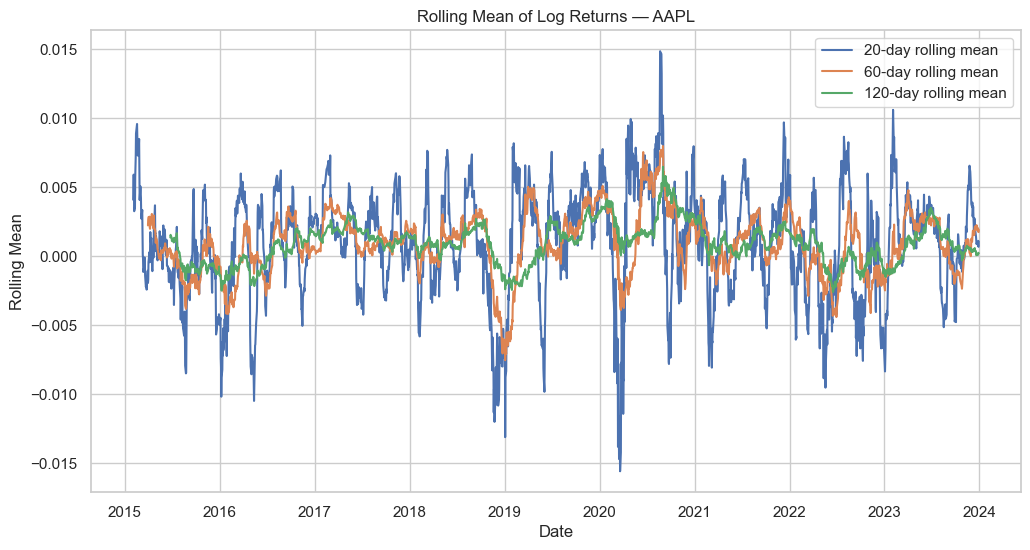

In [13]:
plt.figure(figsize=(12,6))
plt.plot(log_ret.index, roll_mean_20,  label="20-day rolling mean")
plt.plot(log_ret.index, roll_mean_60,  label="60-day rolling mean")
plt.plot(log_ret.index, roll_mean_120, label="120-day rolling mean")

plt.title(f"Rolling Mean of Log Returns — {asset}")
plt.xlabel("Date")
plt.ylabel("Rolling Mean")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
adf_result = adfuller(log_ret)

print("=== ADF Test Result ===")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

=== ADF Test Result ===
ADF Statistic: -14.715252172865961
p-value: 2.80658020114716e-27
Critical Value (1%): -3.43325450880204
Critical Value (5%): -2.862823135013053
Critical Value (10%): -2.567453072861103


## Task 4 - Volatility Regimes
We try to study the trend in volatility more deeply. From the ACF/PACF plot we know that volatility tends to cluster that is the market is either in a high volatility state (greater daily fluctuations) or low volatility state (stable prices, quiet markets).

Formally we can treat volatility as a *conditional standard deviation of returns*, conditioned on the history observed so far. We *cannot* predict *true* volatility for a given day based on the single return value, hence we try to estimate it using the past information. For this we look at two indicators of volatility:

1.  **Rolling Window Volatility:** Simple Moving Average (SMA) of standard deviation.
2.  **EWMA Volatility:** Exponentially Weighted Moving Average. This gives more weight to recent events. It is given by $\sigma_t^2 = (1-\lambda)r_t^2 + \lambda \sigma_{t-1}^2$.

**Steps:**
* Pick an asset and use data covering the **Feb-Mar 2020 COVID crash**.
* Compute two volatility estimates on the Log Returns:
    1.  **Rolling 20-day Volatility:** Standard deviation over a 20-day window.
    2.  **EWMA Volatility (RiskMetrics):** Use a decay factor $\lambda = 0.94$.
        * *Hint:* In pandas `df.ewm()`, the parameter `alpha` corresponds to $1 - \lambda$. So, use `alpha=0.06`.
* **Analysis:**
    * Plot both estimates on the same chart.
    * Which is smoother?
    * Which estimator reacts faster to the sudden crash in March 2020?
    * Which one would you prefer for risk management?
* **Regime Detection:** Compute the 60th percentile of your EWMA volatility series. Shade the regions on the plot where volatility exceeds this level.

* **Bonus:** A good volatility model "standardizes" the returns well. Calculate $z_t = r_t / \hat{\sigma}_t$. If the model is good, $z_t$ should have $Var \approx 1$. Check the variance of $z_t$ and plot its histogram.

In [15]:
# Task 4 - Volatility Regimes (SMA vs EWMA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose asset and range (we'll use long-term data and zoom to Feb-Mar 2020)
asset = "AAPL"   # change as needed
# if you prefer medium-term, change the source to med_adj
source_df = long_adj  # long_adj expected from earlier cells

In [16]:
# 1) Compute log returns (daily)
log_ret = np.log(source_df[asset] / source_df[asset].shift(1)).dropna()

# 2) Choose zoom window around Feb-Mar 2020 (to highlight COVID crash)
zoom_start = "2020-01-01"
zoom_end   = "2020-06-30"
log_ret_zoom = log_ret.loc[zoom_start:zoom_end]

# 3) Rolling SMA volatility: 20-day rolling std of log returns
window = 20
sma_var = log_ret_zoom.rolling(window=window).var()   # var per day
sma_sigma = np.sqrt(sma_var)

# 4) EWMA (RiskMetrics) with lambda=0.94
lam = 0.94
alpha = 1 - lam  # pandas ewm uses alpha parameter
# compute EWMA variance on squared returns using pandas ewm (adjust=False to match recurrence)
ewma_var = (log_ret_zoom**2).ewm(alpha=alpha, adjust=False).mean()
ewma_sigma = np.sqrt(ewma_var)

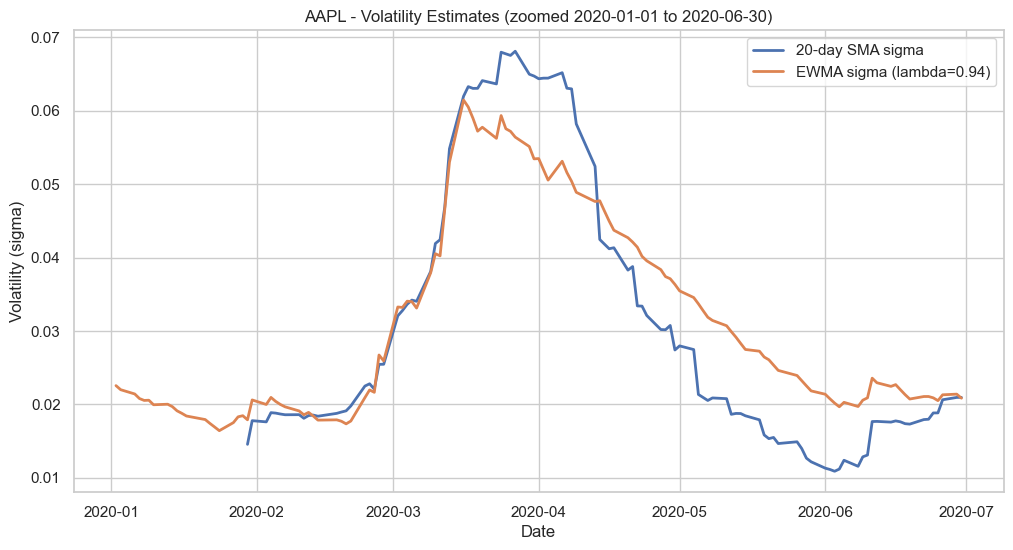

In [17]:
# 5) Plot both on the same chart
plt.figure(figsize=(12,6))
plt.plot(sma_sigma.index, sma_sigma.values, label=f"{window}-day SMA sigma", linewidth=2)
plt.plot(ewma_sigma.index, ewma_sigma.values, label=f"EWMA sigma (lambda={lam})", linewidth=2)
plt.title(f"{asset} - Volatility Estimates (zoomed {zoom_start} to {zoom_end})")
plt.xlabel("Date")
plt.ylabel("Volatility (sigma)")
plt.legend()
plt.grid(True)
plt.show()

60th percentile of EWMA sigma (zoom): 0.030236


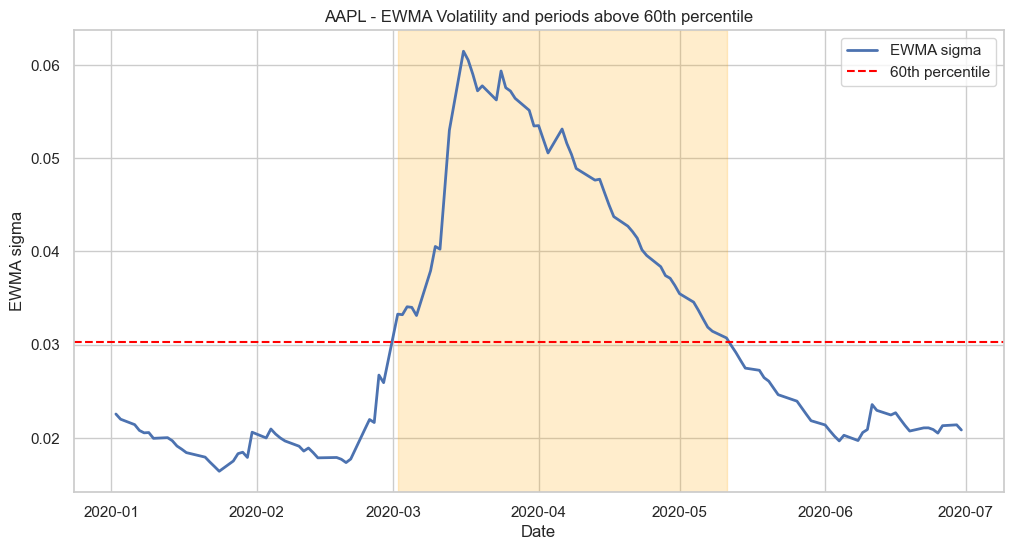

In [18]:
# 6) 60th percentile of EWMA volatility and shading periods where EWMA > threshold
threshold = ewma_sigma.quantile(0.60)
print(f"60th percentile of EWMA sigma (zoom): {threshold:.6f}")

plt.figure(figsize=(12,6))
plt.plot(ewma_sigma.index, ewma_sigma.values, label="EWMA sigma", linewidth=2)
plt.axhline(threshold, color='red', linestyle='--', label="60th percentile")
# shade segments where EWMA > threshold
above = ewma_sigma > threshold
# find contiguous ranges
start = None
for date, cond in above.items():
    if cond and start is None:
        start = date
    if not cond and start is not None:
        plt.axvspan(start, prev_date, color='orange', alpha=0.2)
        start = None
    prev_date = date
# if last segment ends at the end
if start is not None:
    plt.axvspan(start, prev_date, color='orange', alpha=0.2)

plt.title(f"{asset} - EWMA Volatility and periods above 60th percentile")
plt.xlabel("Date")
plt.ylabel("EWMA sigma")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# 7) Simple smoothness / reaction diagnostics:
#   - Smoothness: compare std of daily changes of each sigma (lower => smoother)
sma_diff_std = (sma_sigma.diff().dropna()).std()
ewma_diff_std = (ewma_sigma.diff().dropna()).std()
print(f"SMA sigma daily-diff std: {sma_diff_std:.6e}")
print(f"EWMA sigma daily-diff std: {ewma_diff_std:.6e}")

#   - Reactivity: compare correlation with absolute returns (abs return should spike with volatility)
corr_sma = sma_sigma.corr(log_ret_zoom.abs())
corr_ewma = ewma_sigma.corr(log_ret_zoom.abs())
print(f"Correlation (SMA sigma, |returns|): {corr_sma:.4f}")
print(f"Correlation (EWMA sigma, |returns|): {corr_ewma:.4f}")

SMA sigma daily-diff std: 2.346520e-03
EWMA sigma daily-diff std: 1.744994e-03
Correlation (SMA sigma, |returns|): 0.4434
Correlation (EWMA sigma, |returns|): 0.4660


In [20]:
# 8) Bonus metric: z_t = r_t / sigma_hat, check Var(z_t) for each estimator
# Align series and drop NaNs
df_diag = pd.DataFrame({
    "r": log_ret_zoom,
    "sma_sigma": sma_sigma,
    "ewma_sigma": ewma_sigma
}).dropna()

df_diag["z_sma"] = df_diag["r"] / df_diag["sma_sigma"]
df_diag["z_ewma"] = df_diag["r"] / df_diag["ewma_sigma"]

var_z_sma = df_diag["z_sma"].var()
var_z_ewma = df_diag["z_ewma"].var()
mean_z_sma = df_diag["z_sma"].mean()
mean_z_ewma = df_diag["z_ewma"].mean()

print("\nBonus metric (should be ~1 for a well-scaled volatility estimator):")
print(f"Var(z) using SMA:  {var_z_sma:.4f}   mean(z): {mean_z_sma:.4e}")
print(f"Var(z) using EWMA: {var_z_ewma:.4f}   mean(z): {mean_z_ewma:.4e}")


Bonus metric (should be ~1 for a well-scaled volatility estimator):
Var(z) using SMA:  1.1618   mean(z): 8.6367e-02
Var(z) using EWMA: 0.9584   mean(z): 3.5708e-02


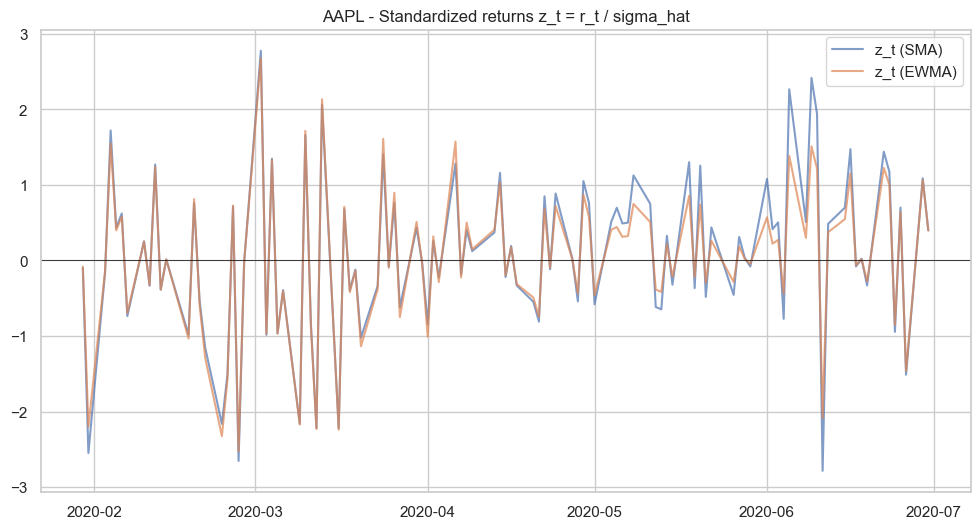

In [21]:
# 9) Quick plots of standardized returns for visual inspection
plt.figure(figsize=(12,6))
plt.plot(df_diag.index, df_diag["z_sma"], label="z_t (SMA)", alpha=0.7)
plt.plot(df_diag.index, df_diag["z_ewma"], label="z_t (EWMA)", alpha=0.7)
plt.axhline(0, color='black', linewidth=0.5)
plt.title(f"{asset} - Standardized returns z_t = r_t / sigma_hat")
plt.legend()
plt.grid(True)
plt.show()

## Task 5 - Time Horizons and the "Normal" Illusion
Short-term markets are noisy and dangerous (fat tails), while long-term data looks smoother. We can prove this statistically using **Skew** and **Kurtosis**.

**Theory:**
* **Skewness:** Measures asymmetry. (Negative skew = frequent small gains, few extreme losses).
* **Kurtosis:** Measures "tailedness". (High kurtosis = frequent extreme events/crashes).
* **Normal Distribution:** Skew $\approx 0$, Kurtosis $\approx 3$ (or Excess Kurtosis $\approx 0$).

**Steps:**
1.  Take your **Long Term** data for one asset (e.g., NVDA or TSLA).
2.  Resample the prices to get **Weekly** and **Monthly** closes.
    * Use `df['Adj Close'].resample('W').last()` and `...resample('M').last()`.
3.  Compute Log Returns for all three series: Daily, Weekly, Monthly.
4.  **The Test:**
    * Calculate **Skew** and **Kurtosis** for each of the three return series.
    * *Question:* How do these values change as the time horizon increases? Do they get closer to 0 and 3?
5.  **Visualization:**
    * Plot the **Histograms** of the Daily returns vs. Monthly returns on the same plot.
    * *Tip:* You will need to standardize them (subtract mean, divide by std dev) to overlay them meaningfully.
    * *Observation:* Look at the tails. Which one has "fatter" tails (more extreme outliers)?

**Key Takeaway:**
Daily returns often violate the "Normal Distribution" assumption used in many financial models. Long-term returns fit it better. This is called *Aggregational Gaussianity*.

**Bonus:** This is a direct application of a simple yet well-known result in asymptotic statistics. Can you find out what it is and state how it explains this observation?

/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/2036779246.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  long_data = yf.download(



Skewness & Kurtosis:
                           Skew              Kurtosis
Daily     [0.17317137830162047]    [9.86293440863753]
Weekly    [0.16776511548885945]  [4.3154977712521205]
Monthly  [-0.17867044500245166]   [3.791032736583933]


/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/2036779246.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = prices.resample("M").last()


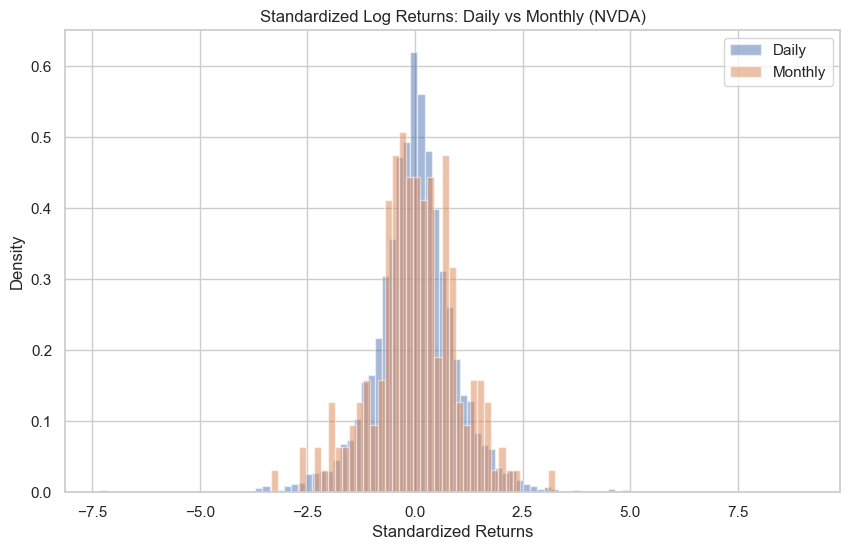

In [ ]:
# Task 5
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# -------------------------------
# 1. Download long-term data
# -------------------------------
ticker = "NVDA"

long_data = yf.download(
    ticker,
    start="2010-01-01",
    progress=False
)

# -------------------------------
# 2. Select price column
# (Adj Close may not exist → fallback to Close)
# -------------------------------
if "Adj Close" in long_data.columns:
    prices = long_data["Adj Close"]
else:
    prices = long_data["Close"]

prices = prices.dropna()

# -------------------------------
# 3. Resample prices
# -------------------------------
weekly_prices = prices.resample("W").last()
monthly_prices = prices.resample("M").last()

# -------------------------------
# 4. Compute log returns
# -------------------------------
daily_ret = np.log(prices / prices.shift(1)).dropna()
weekly_ret = np.log(weekly_prices / weekly_prices.shift(1)).dropna()
monthly_ret = np.log(monthly_prices / monthly_prices.shift(1)).dropna()

# -------------------------------
# 5. Skewness & Kurtosis
# -------------------------------
stats = pd.DataFrame({
    "Skew": [
        skew(daily_ret),
        skew(weekly_ret),
        skew(monthly_ret)
    ],
    "Kurtosis": [
        kurtosis(daily_ret, fisher=False),
        kurtosis(weekly_ret, fisher=False),
        kurtosis(monthly_ret, fisher=False)
    ]
}, index=["Daily", "Weekly", "Monthly"])

print("\nSkewness & Kurtosis:")
print(stats)

# -------------------------------
# 6. Standardize returns
# -------------------------------
daily_std = (daily_ret - daily_ret.mean()) / daily_ret.std()
monthly_std = (monthly_ret - monthly_ret.mean()) / monthly_ret.std()

# -------------------------------
# 7. Histogram comparison
# -------------------------------
plt.figure(figsize=(10, 6))
plt.hist(daily_std, bins=100, density=True, alpha=0.5, label="Daily")
plt.hist(monthly_std, bins=40, density=True, alpha=0.5, label="Monthly")
plt.legend()
plt.title("Standardized Log Returns: Daily vs Monthly (NVDA)")
plt.xlabel("Standardized Returns")
plt.ylabel("Density")
plt.show()
'''We can see that the daily histogram bars don't die out completely so they have a fat tail. As we increase the time period the distribut
ion approaches that of a normal distribution. Central limit theorem explains this since the longer time period returns are the sum of many
independent daily returns and so their distribution approaches that of a normal gaussian'''


## Task 6 - Smart investing
Calculate how many **RTX 4090s** (approx. price $1,600$) you could afford *today* if you had invested **$1,000** in NVIDIA on the day you were born.

In [ ]:
# Task 6
import yfinance as yf
import pandas as pd

# Your birth year
start_date = "2006-01-01"
today = pd.Timestamp.today().strftime("%Y-%m-%d")

# 1. Download NVDA price history (auto-adjusted)
nvda = yf.download("NVDA", start=start_date, end=today)

# 2. Earliest trading day
first_price_date = nvda.index[0]

# Select correct price column
price_col = "Adj Close" if "Adj Close" in nvda.columns else "Close"

# Extract scalar float (not a Series)
first_price = float(nvda[price_col].iloc[0])

print("First trading day:", first_price_date.date())
print("Price on that day:", round(first_price, 4))

# 3. Compute shares
investment = 1000
shares = investment / first_price

print(f"\nIf you invested $1000 in NVDA in {first_price_date.year}:")
print(f"You would have bought {shares:.2f} shares.")

# 4. Latest price
latest_price = float(nvda[price_col].iloc[-1])
current_value = shares * latest_price

print("\nLatest NVDA Price:", round(latest_price, 4))
print(f"Current value of your investment: ${current_value:,.2f}")

# 5. RTX 4090 count
price_4090 = 1600
num_4090s = current_value / price_4090

print(f"\nYou could buy approximately {num_4090s:.1f} RTX 4090 GPUs today.")

/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/1887324326.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download("NVDA", start=start_date, end=today)
[*********************100%***********************]  1 of 1 completed

First trading day: 2006-01-03
Price on that day: 0.292

If you invested $1000 in NVDA in 2006:
You would have bought 3424.52 shares.

Latest NVDA Price: 176.29
Current value of your investment: $603,708.46

You could buy approximately 377.3 RTX 4090 GPUs today.



/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/1887324326.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  first_price = float(nvda[price_col].iloc[0])
/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_33567/1887324326.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(nvda[price_col].iloc[-1])
